In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cma
import pandas as pd

import sys
sys.path.append('../lib/estool')
from es import SimpleGA, CMAES, PEPG, OpenES

sys.path.append('../src')
from fit_sde import match
from utils.data import load_data, get_keys, get_names, get_market_cap, get_history
from cointegration import find_cointegrated_pairs

In [4]:
# from https://github.com/CMA-ES/pycma/blob/master/cma/fitness_functions.py
def rastrigin(x):
    """Rastrigin test objective function, shifted by 10. units away from origin"""
    x = np.copy(x)
    x -= 10.0
    if not np.isscalar(x[0]):
        N = len(x[0])
        return -np.array([10 * N + sum(xi**2 - 10 * np.cos(2 * np.pi * xi)) for xi in x])
    N = len(x)
    return -(10 * N + sum(x**2 - 10 * np.cos(2 * np.pi * x)))

fit_func = rastrigin

## Get distributions of real and simulated data

In [5]:
import statsmodels.api as sm
from stochastic import ornstein_uhlenbeck_levels, ModelParameters
import seaborn as sns
from scipy.stats import norm, entropy

def construct_data_df():
    markets, exception = load_data()
    keys = get_market_cap(markets, 'USDT')
    data_close = get_history(keys[:10], timeframe='1m', limit=2000)
    data_close = data_close.dropna()
    scores, pvalues, pairs = find_cointegrated_pairs(data_close)

    data = {'market1': [k[0] for k in pairs.keys()],
            'market2': [k[1] for k in pairs.keys()],
            'p-value': [v[1] for v in pairs.values()]}

    df = pd.DataFrame(data).sort_values('p-value').reset_index(drop=True)
    df['pair'] = df["market1"].map(str) + ' -- ' + df["market2"]
    pair = df['pair'][0] # choose first pair
    [market1, market2] = pair.split(' -- ')

    # Fit residual
    x1 = data_close[market1].values
    x2 = data_close[market2].values
    r = sm.OLS(x1,x2).fit().params[0]

    df_x = pd.DataFrame({'x1':x1, 'r*x2':r*x2, 'z':x1 - r*x2}, index=data_close.index)
    return df_x

df_x = construct_data_df()

mp = ModelParameters()
example = ornstein_uhlenbeck_levels(mp)

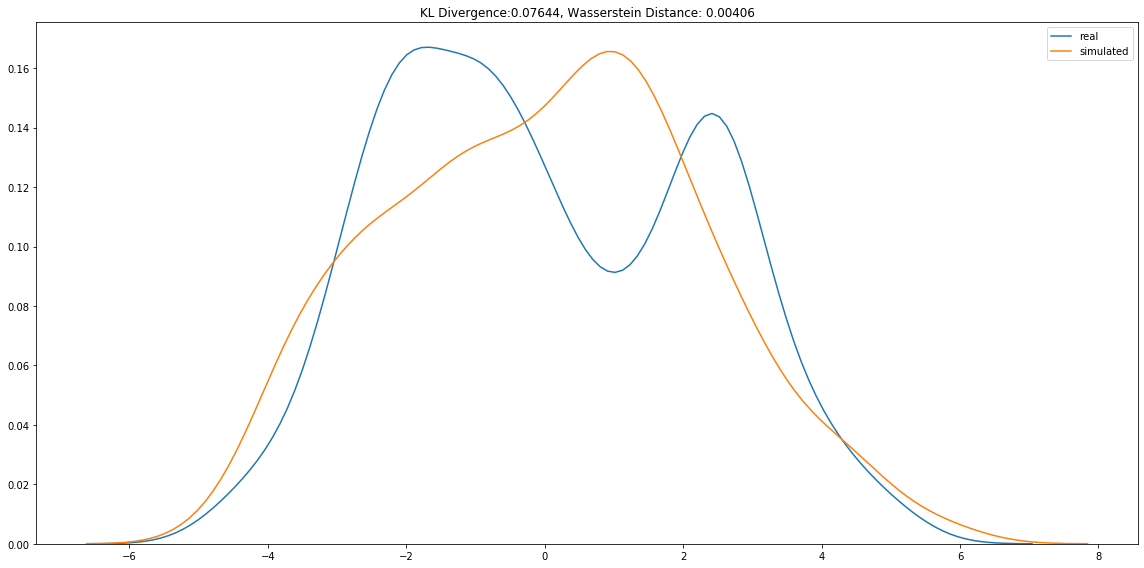

In [6]:
import seaborn as sns
from scipy.stats import norm, entropy, wasserstein_distance

def plot_kld(real, simulated):
    fig3=plt.figure(figsize=(16,8))
    sns.kdeplot(real, label='real')
    kde = sns.kdeplot(match(simulated, real), label='simulated')
    (pdf1_x, pdf1_y) = kde.get_lines()[0].get_data()
    (pdf2_x, pdf2_y) = kde.get_lines()[1].get_data()
    kld = entropy(pdf1_y, pdf2_y)
    wass_d = wasserstein_distance(pdf1_y, pdf2_y)
    kde.set_title('KL Divergence:{0:.5f}, Wasserstein Distance: {1:0.5f}'.format(kld, wass_d))
    plt.tight_layout()
    
mp = ModelParameters(**{'all_r0':0.5, 'all_time':1000, 'all_delta':0.004, 'ou_a':3.0, 'ou_mu':0.5})
example = ornstein_uhlenbeck_levels(mp)
plot_kld(df_x['z'], example)

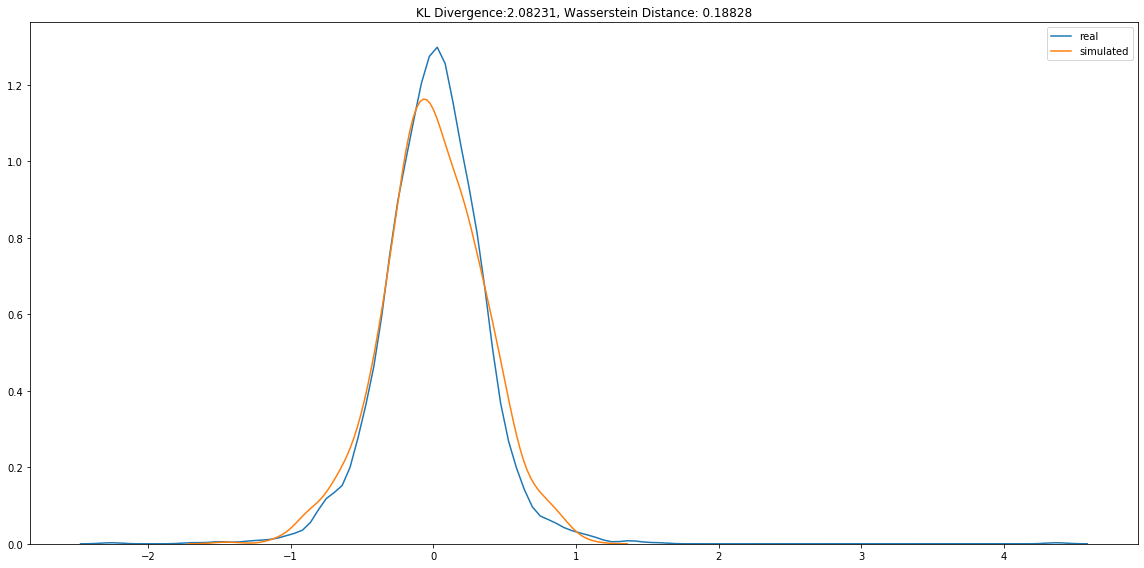

In [7]:
example = ornstein_uhlenbeck_levels(mp)
plot_kld(df_x['z'].diff()[1:], pd.Series(example).diff()[1:])

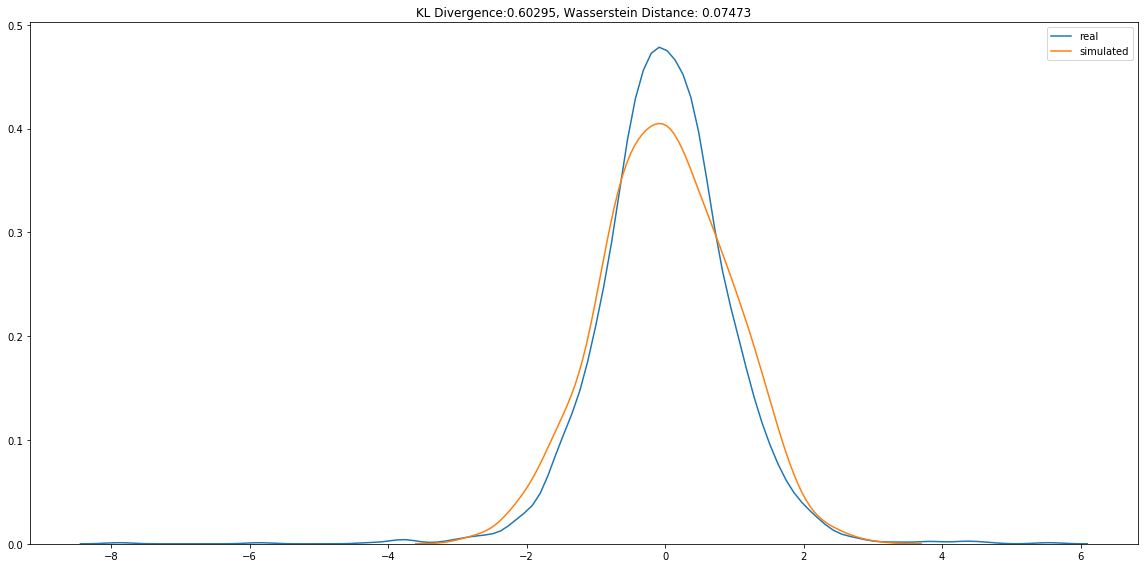

In [8]:
example = ornstein_uhlenbeck_levels(mp)
plot_kld(df_x['z'].diff().diff().diff()[3:], pd.Series(example).diff().diff().diff()[3:])

---

## Optimise by minimising KLD

In [9]:
def kld_fitness(x, df_x=df_x):
    
    import time
    start = time.time()
    
    mp_dict = {
        'all_r0':       {'val':0.5, 'min':0.0, 'max':1.0},
        'all_time':     {'val':800, 'min':100, 'max':2000},
        'all_delta':    {'val':0.004, 'min':0.0, 'max':1.0},
        'ou_a':         {'val':3.0, 'min':0.0, 'max':10.0},
        'ou_mu':        {'val':0.5, 'min':0.0, 'max':1.0},
    }
    
    params = {'all_r0':0.5, 'all_time':800, 'all_delta':0.004, 'ou_a':3.0, 'ou_mu':0.5}
    
    for i,k in enumerate(mp_dict):
        a = mp_dict[k]['max'] - mp_dict[k]['min']
        b = mp_dict[k]['min']
        bounded_x = a/2 * (np.tanh(x[i])+1) + b
        params[k] = bounded_x
                
    params['all_time'] = int(params['all_time'])

    mp = ModelParameters(**params)
    
    try:
        sim = pd.Series(ornstein_uhlenbeck_levels(mp)).diff()[1:]
    except:
        print(x)
        print(params)
        return 0
                               
    real = df_x['z'].diff()[1:]
    try:
        _ = sns.kdeplot(real)
        kde = sns.kdeplot(match(sim, real))
    except:
        print(params)
        return 0
    (pdf1_x, pdf1_y) = kde.get_lines()[0].get_data()
    (pdf2_x, pdf2_y) = kde.get_lines()[1].get_data()
    
    kld = entropy(pdf1_y, pdf2_y)
        
    return 1-kld

In [10]:
MAX_ITERATION = 100  # run each solver for 1000 generations.

# defines a function to use solver to solve fit_func
def test_solver(solver, fit_func):
    history = []
    for j in range(MAX_ITERATION):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        history.append(result[1])
        if (j+1) % 10 == 0:
            print("fitness at iteration", (j+1), result[1])
    print("local optimum discovered by solver:\n", result[0])
    print("fitness score at this local optimum:", result[1])
    return history

In [11]:
NPARAMS = 5          # make this a 100-dimensinal problem.
NPOPULATION = 10     # use population size of 101.

In [12]:


# # defines genetic algorithm solver
# ga = SimpleGA(NPARAMS,               # number of model parameters
#               sigma_init=0.5,        # initial standard deviation
#               popsize=NPOPULATION,   # population size
#               elite_ratio=0.1,       # percentage of the elites
#               forget_best=False,     # forget the historical best elites
#               weight_decay=0.00      # weight decay coefficient
#              )

# ga_history = test_solver(ga, kld_fitness)

In [ ]:
cmaes = CMAES(NPARAMS,
              popsize=NPOPULATION,
              weight_decay=0.0,
              sigma_init = 0.5
          )

cma_history = test_solver(cmaes, kld_fitness)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 5 (seed=674221, Mon Feb 24 23:57:11 2020)
{'all_r0': 0.26727477988850756, 'all_time': 1406, 'all_delta': 0.5168102956599553, 'ou_a': 5.150251989005998, 'ou_mu': 0.819577079769356}
{'all_r0': 0.5092001050233355, 'all_time': 1423, 'all_delta': 0.7598403278762658, 'ou_a': 8.369018759930778, 'ou_mu': 0.7421701921749826}
{'all_r0': 0.28008126089877994, 'all_time': 1021, 'all_delta': 0.32832909742400485, 'ou_a': 9.249048739372805, 'ou_mu': 0.6867324935988282}
{'all_r0': 0.5103896483094194, 'all_time': 520, 'all_delta': 0.6579125041460516, 'ou_a': 8.940889356298783, 'ou_mu': 0.6097298111948265}


/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
../src/stochastic.py:425: RuntimeWarning: overflow encountered in double_scalars
  drift = param.ou_a * (param.ou_mu - ou_levels[i-1]) * param.all_delta
../src/stochastic.py:427: RuntimeWarning: invalid value encountered in double_scalars
  ou_levels.append(ou_levels[i - 1] + drift + randomness)
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWar

{'all_r0': 0.6080482139774953, 'all_time': 1404, 'all_delta': 0.5036850660076888, 'ou_a': 7.286073288186714, 'ou_mu': 0.76271414980395}
{'all_r0': 0.17719840223521893, 'all_time': 724, 'all_delta': 0.7384606403314173, 'ou_a': 9.407475442852515, 'ou_mu': 0.5109985555399843}
{'all_r0': 0.22517105818770738, 'all_time': 1282, 'all_delta': 0.7633059082102197, 'ou_a': 8.43014348044225, 'ou_mu': 0.7873396651022396}
{'all_r0': 0.5977035784703569, 'all_time': 1057, 'all_delta': 0.7010136045502123, 'ou_a': 4.305086604569847, 'ou_mu': 0.46260570039875787}


/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: function values with index [0, 1, 3, 5, 7, 8]/[] are nan/None and will be set to the median value 0.0 (class=CMAEvolutionStrategy method=ask iteration=1)
  ')')
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=0.000000, sigma=3.98e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=2)
  ')')
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: function values with index [0, 1, 2, 4, 6, 7, 8, 9]/[] are nan/None and will be set to the median value 0.0 (class=CMAEvolutionStrategy method=ask iteration=2)
  ')')
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fit

{'all_r0': 0.23284154177097904, 'all_time': 742, 'all_delta': 0.6746986773105963, 'ou_a': 6.334732023149701, 'ou_mu': 0.5552209779810048}
{'all_r0': 0.4999323183768069, 'all_time': 1276, 'all_delta': 0.6163848893969023, 'ou_a': 8.312442454173354, 'ou_mu': 0.5114916243420375}
{'all_r0': 0.02729616151081965, 'all_time': 1427, 'all_delta': 0.3218589950312065, 'ou_a': 8.54737540127333, 'ou_mu': 0.8858923880015551}


/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: function values with index [0, 1, 4, 6, 7, 8, 9]/[] are nan/None and will be set to the median value 0.0 (class=CMAEvolutionStrategy method=ask iteration=3)
  ')')
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=0.000000, sigma=4.10e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=4)
  ')')


{'all_r0': 0.6500544659140737, 'all_time': 815, 'all_delta': 0.6298939353960923, 'ou_a': 7.0683671309559415, 'ou_mu': 0.47098741001470457}


/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: function values with index [1, 2, 3, 4, 5, 6, 7, 8, 9]/[] are nan/None and will be set to the median value 0.0 (class=CMAEvolutionStrategy method=ask iteration=4)
  ')')
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-0.000000, sigma=4.18e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=5)
  ')')


{'all_r0': 0.7694225451650984, 'all_time': 1393, 'all_delta': 0.7029253119742076, 'ou_a': 8.23154595860797, 'ou_mu': 0.47246469780454553}
{'all_r0': 0.8901103630732314, 'all_time': 758, 'all_delta': 0.6440563697100392, 'ou_a': 7.0364816851317205, 'ou_mu': 0.38752110654476624}
{'all_r0': 0.7735495431698471, 'all_time': 1170, 'all_delta': 0.5759389649306764, 'ou_a': 6.879661685612984, 'ou_mu': 0.2841698773422521}
{'all_r0': 0.5426022863051809, 'all_time': 795, 'all_delta': 0.5851523227767887, 'ou_a': 6.053469563015362, 'ou_mu': 0.6779555279926617}
{'all_r0': 0.6919781435649247, 'all_time': 1265, 'all_delta': 0.40703149550630174, 'ou_a': 9.342738622918015, 'ou_mu': 0.23713175758381105}
{'all_r0': 0.7172229876676833, 'all_time': 1397, 'all_delta': 0.6727617376589496, 'ou_a': 6.548340294732084, 'ou_mu': 0.2893817642604649}
{'all_r0': 0.25002170984396205, 'all_time': 941, 'all_delta': 0.4938608073054501, 'ou_a': 7.078771325908457, 'ou_mu': 0.6228024018217573}


/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: function values with index [1, 3, 6, 7]/[] are nan/None and will be set to the median value 0.0 (class=CMAEvolutionStrategy method=ask iteration=5)
  ')')
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-0.000000, sigma=4.18e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=6)
  ')')


{'all_r0': 0.701284108056312, 'all_time': 801, 'all_delta': 0.5312801945973178, 'ou_a': 9.141218379918591, 'ou_mu': 0.5756263258423482}
{'all_r0': 0.8547800635015737, 'all_time': 1179, 'all_delta': 0.6923611203432622, 'ou_a': 8.62336915196836, 'ou_mu': 0.5865614622510594}


/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: function values with index [1, 2, 3, 4, 7, 8, 9]/[] are nan/None and will be set to the median value 0.0 (class=CMAEvolutionStrategy method=ask iteration=6)
  ')')
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-0.000000, sigma=3.74e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=7)
  ')')


{'all_r0': 0.9049793155192521, 'all_time': 785, 'all_delta': 0.7681066942662189, 'ou_a': 5.06605953691002, 'ou_mu': 0.5281850049101158}
{'all_r0': 0.5237797279545258, 'all_time': 1243, 'all_delta': 0.7126936973445417, 'ou_a': 4.811189293920403, 'ou_mu': 0.5782782694389504}
{'all_r0': 0.5201732261516013, 'all_time': 1489, 'all_delta': 0.45684572519269845, 'ou_a': 5.733388669562979, 'ou_mu': 0.646465393753453}
{'all_r0': 0.698244069696393, 'all_time': 1141, 'all_delta': 0.5844451598977383, 'ou_a': 8.42545037900917, 'ou_mu': 0.6274357644074944}
{'all_r0': 0.9615200488212029, 'all_time': 1559, 'all_delta': 0.8193299862844763, 'ou_a': 6.9202487621672315, 'ou_mu': 0.2868151604940932}


/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: function values with index [0, 1, 3, 4, 5, 7]/[] are nan/None and will be set to the median value 0.0 (class=CMAEvolutionStrategy method=ask iteration=7)
  ')')
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=0.000000, sigma=4.00e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=8)
  ')')


{'all_r0': 0.8576093205086737, 'all_time': 1263, 'all_delta': 0.41129037333925716, 'ou_a': 7.085054165202031, 'ou_mu': 0.567019852489395}
{'all_r0': 0.7768301228876286, 'all_time': 959, 'all_delta': 0.8670781529928066, 'ou_a': 5.959996959546771, 'ou_mu': 0.3445872017720766}


/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: function values with index [1, 3, 4, 6, 7, 8, 9]/[] are nan/None and will be set to the median value 0.0 (class=CMAEvolutionStrategy method=ask iteration=8)
  ')')
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/cma/utilities/utils.py:333: UserWarning: flat fitness (f=-0.000000, sigma=4.79e-01).
                    For small sigma, this could indicate numerical convergence.
                    Otherwise, please (re)consider how to compute the fitness more elaborately. (iteration=9)
  ')')


{'all_r0': 0.9844799675213282, 'all_time': 1419, 'all_delta': 0.8672009341532265, 'ou_a': 3.552758518783994, 'ou_mu': 0.23615070737143534}
{'all_r0': 0.7901587934603624, 'all_time': 1539, 'all_delta': 0.8042357743412569, 'ou_a': 6.6638408503922015, 'ou_mu': 0.376445810764137}
{'all_r0': 0.9679965391095624, 'all_time': 1332, 'all_delta': 0.823652907174473, 'ou_a': 7.0720243165780445, 'ou_mu': 0.33152847456057805}
{'all_r0': 0.9981684280178174, 'all_time': 1524, 'all_delta': 0.713248784638869, 'ou_a': 4.888332502277067, 'ou_mu': 0.31139954108026624}
{'all_r0': 0.9739705703903094, 'all_time': 1694, 'all_delta': 0.7289495419108346, 'ou_a': 7.180606793788607, 'ou_mu': 0.49909977807059325}


In [ ]:
# Create a new figure of size 8x6 points, using 100 dots per inch
best_history = [0] * MAX_ITERATION
plt.figure(figsize=(16,8), dpi=150)

# optimum_line, = plt.plot(best_history, color="black", linewidth=0.5, linestyle="-.", label='Global Optimum')
ga_line, = plt.plot(ga_history, color="green", linewidth=1.0, linestyle="-", label='GA')
# oes_line, = plt.plot(oes_history, color="orange", linewidth=1.0, linestyle="-", label='OpenAI-ES')
# pepg_line, = plt.plot(pepg_history, color="blue", linewidth=1.0, linestyle="-", label='PEPG / NES')
# cma_line, = plt.plot(cma_history, color="red", linewidth=1.0, linestyle="-", label='CMA-ES')

plt.legend(handles=[optimum_line, ga_line, cma_line, pepg_line, oes_line], loc=4)

# Set x limits
plt.xlim(0,2500)

plt.xlabel('generation')
plt.ylabel('fitness')

# plt.savefig("./rastrigin_10d.svg")

plt.show()

../src/stochastic.py:425: RuntimeWarning: overflow encountered in double_scalars
  drift = param.ou_a * (param.ou_mu - ou_levels[i-1]) * param.all_delta
../src/stochastic.py:427: RuntimeWarning: invalid value encountered in double_scalars
  ou_levels.append(ou_levels[i - 1] + drift + randomness)
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/athon/anaconda3/envs/quantlit/lib/python3.7/site-packages/numpy

ZeroDivisionError: 0.0 cannot be raised to a negative power

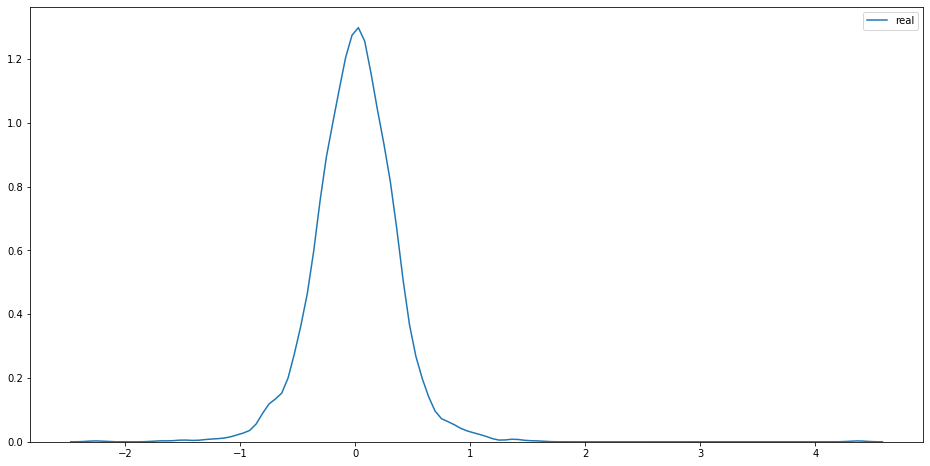

In [9]:
params = {'all_r0': 0.12105303840358866, 'all_time': 1309, 'all_delta': 0.5284511285739563, 'ou_a': 6.314871189863608, 'ou_mu': 0.18653455101657918}
mp = ModelParameters(**params)
example = ornstein_uhlenbeck_levels(mp)
plot_kld(df_x['z'].diff()[1:], pd.Series(example).diff()[1:])

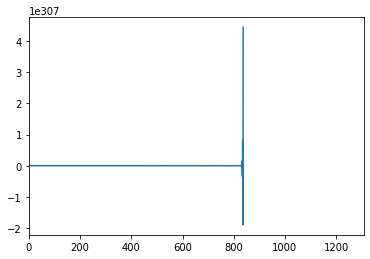

In [15]:
pd.Series(example).plot()

---
---